In [62]:
from pandas import read_csv, DataFrame
from pandas.plotting import autocorrelation_plot
from datetime import datetime, timedelta
from matplotlib import pyplot
from pmdarima import auto_arima, ARIMA, metrics
import numpy as np
from matplotlib.pyplot import figure


def parser(x):
    return datetime.strptime(x, '%m/%d/%Y')

<Figure size 640x480 with 0 Axes>

Index(['price_eurusd', 'open_eurusd', 'high_eurusd', 'low_eurusd',
       'change_eurusd', 'bid', 'price_sp500', 'open_sp500', 'high_sp500',
       'low_sp500', 'change_sp500'],
      dtype='object')


<AxesSubplot:title={'center':'Evolución del precio del dólar en colones'}, xlabel='date', ylabel='USD'>

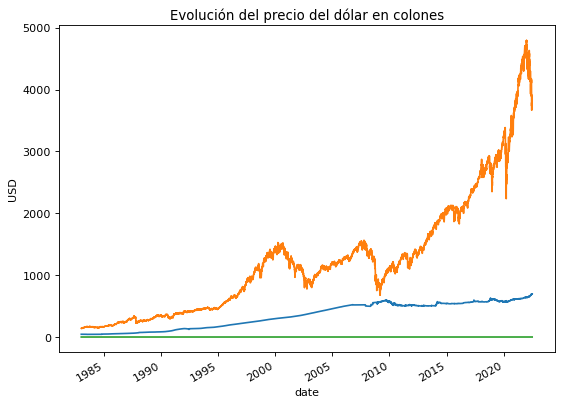

In [64]:
data = read_csv('full_dataset.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser).drop(['ask'], axis=1)
print(data.columns)
figure(figsize=(8, 6), dpi=80)
data['bid'].plot(ylabel='CRC', title="Evolución del precio del dólar en colones")
data['price_sp500'].plot(ylabel='USD', title="Evolución del precio del euro en dólares")
data['price_eurusd'].plot(ylabel='USD', title="Evolución del precio del dólar en colones")
# model = ARIMA(series, order=(5, 1, 0))
# model_fit = model.fit()

# print(model_fit.summary())

# residuals = DataFrame(model_fit.resid)
# residuals.plot()
# pyplot.show()

# residuals.plot(kind='kde')
# pyplot.show()

# print(residuals.describe())

In [ ]:
model = auto_arima(data['bid'], m=12, seasonal=True, start_p=0, start_q=0, max_order=4, test='adf', stepwise=True, trace=True)

In [3]:
# ARIMA(4,1,3)(2,0,1)[12] 
model = ARIMA(order=(4, 1, 3), seasonal_order=(2,0,1,12))
# train = data[(data.get_level_values(0) >= datetime.strptime('2005-05-15', "%Y-%m-%d")) and data.index.get_level_values(0) <= datetime.strptime('2017-04-30', "%Y-%m-%d")]
# data > datetime.strptime('2005-05-15', "%Y-%m-%d")
train = data['1983-01-04' : '2021-06-05']
test = data['2021-06-06' : '2022-07-01']

In [4]:
model.fit(data['bid'])

c:\Users\chris\miniconda3\envs\agvd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chris\miniconda3\envs\agvd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chris\miniconda3\envs\agvd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(4, 1, 3), seasonal_order=(2, 0, 1, 12))

27111.137129403716

<Figure size 640x480 with 0 Axes>

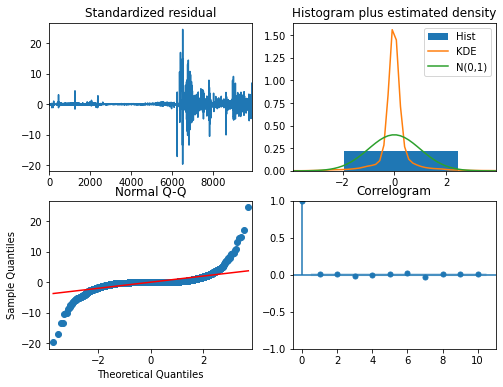

In [67]:
figure(figsize=(8, 6), dpi=80)
model.plot_diagnostics(figsize=(8, 6))
model.aic()

In [36]:
forecast = model.predict(n_periods=18, return_conf_int=True)

In [37]:
lower_bounds = []
upper_bounds = []
for bounds in forecast[1]:
    lower_bounds.append(bounds[0])
    upper_bounds.append(bounds[1])


In [50]:
def forecast_error(days, true_values, predicted_values):
    error_values = []
    for i in range(1, days + 1):
        error_values.append(metrics.smape(true_values[:i], predicted_values[:i]))
    return error_values


In [38]:
day = datetime.strptime("2022-07-02", "%Y-%m-%d")
delta = timedelta(days=18)
dates = []
for i in range(18):
    dates.append(day + timedelta(days=i))
dates = np.array(dates, dtype='datetime64[s]')

# forecast[0]
forecast_df = DataFrame(data=forecast[0], index=dates, columns=['bid'])
forecast_df.index.name = 'date'


lower_df = DataFrame(data=lower_bounds, index=dates, columns=['bid'])
upper_df = DataFrame(data=upper_bounds, index=dates, columns=['bid'])
lower_df.index.name = 'date'
upper_df.index.name = 'date'


new_data = read_csv('current_data.csv', header=0, parse_dates=[0], index_col=0, date_parser= lambda x: datetime.strptime(x, '%d-%b-%y'))

0.8140002162414084

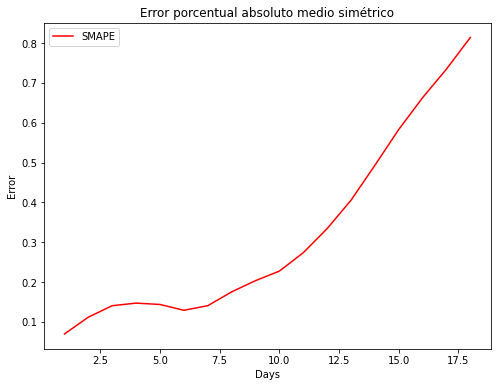

In [79]:
errors = forecast_error(18, new_data['bid'].to_numpy(), forecast[0])
days = [i for i in range(1, 19)]
error_df = DataFrame(data=errors, index=days, columns=['SMAPE'])
error_df.index.namy = 'Days'
error_df.plot(ls='-', color='r', xlabel='Days', ylabel='Error', figsize=(8, 6), title="Error porcentual absoluto medio simétrico").figure.savefig("smape.jpg")

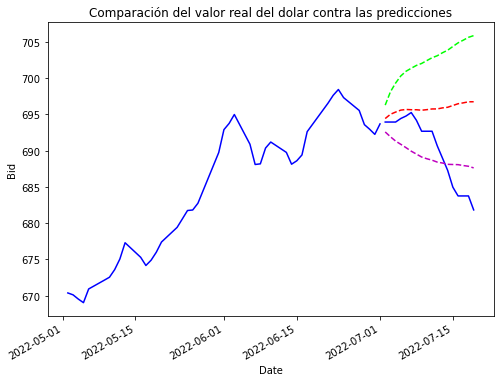

In [82]:
data['2022-05-01' : '2022-07-01']['bid'].plot(ls="-", color="b", ylabel='Bid', title="Comparación del valor real del dolar contra las predicciones")
forecast_df['bid'].plot(ls="--", color="r")
new_data['bid'].plot(ls='-', color='b')
lower_df['bid'].plot(ls='--', color='m')
upper_df['bid'].plot(ls='--', color='lime', xlabel="Date", figsize=(8, 6)).figure.savefig("arima.jpg")